# Proyecto 2: Detección de preguntas duplicadas

### Procesado del Lenguaje Natural

**Pablo Martínez Olmos, Angel Navia Vázquez**

  * 1.1 (January 2025) Revised and updated version

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~navia/figures/logo_uc3m_foot.jpg' width=400 />

AUTOR(ES): **escribir aquí el nombre o nombres de los autores (apellidos, nombre)**

- Barcos Gambaro, Jhonatan



En este segundo proyecto vamos a practicar con las parametrizaciones de palabras y textos que hemos visto durante el curso y las aplicaremos al problema de encontrar preguntas duplicadas en una base de datos real ([Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data)).

En este proyecto, **deberemos** utilizar **tres métodos distintos** para vectorizar cada una de las 10.000 preguntas:

- **TF-IDF** (elija las opciones que considere más adecuadas).

- **LSA** a partir del TF-IDF anterior (elija las opciones que considere más adecuadas).

- **Text embedding** de cada pregunta (elija las opciones que considere más adecuadas).

Para cada uno de estos tres métodos, determinar la fracción de casos ("accuracy") en los que la pregunta duplicada **se encuentra entre los K vecinos más cercanos**. Dibuje dicha "accuracy" en función de $K$, para $K=1,\ldots,10$.

A continuación se proporciona un código base sobre el que hay que añadir las partes ausentes, marcadas con ``<INSERTAR CODIGO>``.

**IMPORTANTE, no modificar o eliminar el código proporcionado, el notebook debe ejecutar sin error y los resultados mostrados en pantalla y las gráficas deben ser los indicados.**

Los datos se proporcionan en el fichero **"QUORA_DUPLICATES_10000.csv"**, en el que la primera columna es el texto de la pregunta, y en la segunda columna hay un identificador para localizar preguntas duplicadas (para cada identificador, hay dos frases que se consideran equivalentes o duplicadas).


In [1]:
import time
t_ini = time.time()

# Importe las demás librerías necesarias
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from scipy import sparse

In [2]:
# Cargamos los datos
from google.colab import drive
drive.mount("/content/drive")
MYDRIVE="/content/drive/MyDrive/2_CUATRI/NLP/LAB2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cargamos el dataset desde Drive
df = pd.read_csv(MYDRIVE + "QUORA_DUPLICATES_10000.csv")

In [4]:
#
preguntas = df.iloc[:, 0].tolist()
ids = df.iloc[:, 1].tolist()
#

print("Leídas {} preguntas con {} identificadores diferentes.".format(len(preguntas), len(set(ids))))

Leídas 9999 preguntas con 5000 identificadores diferentes.


In [5]:
print('Ejemplo de dos preguntas duplicadas\n')
id_elegido = 136

# Posiciones en la lista de las dos preguntas con mismo id_elegido
pos = [i for i, id in enumerate(ids) if id == id_elegido]

if ids[pos[0]] == ids[pos[1]]:
  print("La búsqueda ha sido exitosa. \n\nLa pregunta más parecida a:\n")
  print('-'*50)
  print(preguntas[pos[0]])
  print('-'*50)

  print("\nEs la pregunta:\n")
  print('-'*50)
  print(preguntas[pos[1]])
  print('-'*50)
else:
  print('#'*50)
  print("ERROR: los identificadores no coinciden.")
  print('#'*50)


Ejemplo de dos preguntas duplicadas

La búsqueda ha sido exitosa. 

La pregunta más parecida a:

--------------------------------------------------
What are the requirements for selection into MIT?
--------------------------------------------------

Es la pregunta:

--------------------------------------------------
How can I get entry in MIT?
--------------------------------------------------


# 0. PREPROCESSING

In [6]:
# Creamos la función de preprocesamiento adaptando la función limpiar_texto() del Notebook 2 con el diccionario inglés
nlp = spacy.load("en_core_web_md")

def limpiar_texto(textos):
    textos_limpios = []
    for doc in nlp.pipe(textos):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        textos_limpios.append(" ".join(tokens))
    return textos_limpios


In [7]:
# Preprocesamos las preguntas a través de la función definida anteriormente
preguntas_cleaned = limpiar_texto(preguntas)

# Visualizamos un ejemplo
ejemplo_idx = 42

print("Pregunta original:")
print(preguntas[ejemplo_idx])
print("\nPregunta preprocesada:")
print(preguntas_cleaned[ejemplo_idx])


Pregunta original:
Does green tea really help in losing weight?

Pregunta preprocesada:
green tea help lose weight


In [8]:
# Estos vectores, de longitud 10, almacenan las accuracies de cada método para diferente número de vecinos, desde 1 a 10.
TFIDF_accuracies = []
LSA_accuracies = []
Embedd_accuracies = []

k_range = list(range(1, 11))  # [1, 2, 3, ..., 10]

In [9]:
Embedd_accuracies = []

In [10]:
# Definimos una función auxiliar para hallar la accuracy de cada método expuesto a  continuación
def calcular_accuracy(indices, ids, k_max=10):
    accuracies = []
    for k in range(1, k_max + 1):
        aciertos = 0
        for i in range(len(ids)):
            vecinos = indices[i][1:k+1]
            if any(ids[j] == ids[i] and j != i for j in vecinos):
                aciertos += 1
        accuracies.append(aciertos / len(ids))
    return accuracies


# 1. TF-IDF


In [11]:
# Realizamos la vectorización Tf-Idf
vectorizer_tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    max_features=10000,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_tfidf = vectorizer_tfidf.fit_transform(preguntas_cleaned)


In [12]:
#Normalizamos nuestra matriz dispersa generada con Tf-Idf a través de está función adaptada del Notebook 3
def normalize_sparse_vector(s):
    norm_s = np.array(np.sqrt(s.multiply(s).sum(1)))
    norm_s[norm_s == 0] = 1
    return s.multiply(sparse.csr_matrix(1 / norm_s))

X_tfidf_norm = normalize_sparse_vector(X_tfidf)

In [13]:
# Utilizamos KNN para hallar los vecinos más cercanos y detectar preguntas duplicadas
knn = NearestNeighbors(n_neighbors=11, metric='euclidean')
knn.fit(X_tfidf_norm)

distancias, indices_tfidf = knn.kneighbors(X_tfidf_norm)

# Hallamos las accuracies
TFIDF_accuracies = calcular_accuracy(indices_tfidf, ids, k_max=10)

# 2. LSA


In [14]:
# A continuación aplicamos LSA (Trucated SVD) a la transformación Tf-Idf anterior
n_components = 100
lsa = TruncatedSVD(n_components, random_state=42)
lsa_matrix = lsa.fit_transform(X_tfidf)

# Utilizamos KNN para hallar los vecinos más cercanos y detectar preguntas duplicadas
nbrs_lsa = NearestNeighbors(n_neighbors=11, metric='cosine').fit(lsa_matrix)
_, indices_lsa = nbrs_lsa.kneighbors(lsa_matrix)

# Hallamos las accuracies
LSA_accuracies = calcular_accuracy(indices_lsa, ids, k_max=10)


# 3. EMBEDDINGS

In [15]:
# Realizamos un nuevo procesamiento de las preguntas sin limpiar con spacy
docs_spacy = list(nlp.pipe(preguntas, disable=["ner", "parser"]))

# Extraemos los vectores (embeddings por documento)
X_embed = np.array([doc.vector for doc in docs_spacy])

# Vecinos más cercanos usando distancia euclídea
knn_embed = NearestNeighbors(n_neighbors=11, metric='euclidean')
knn_embed.fit(X_embed)
_, indices_embed = knn_embed.kneighbors(X_embed)

# Calculamos accuracy@K
Embedd_accuracies = calcular_accuracy(indices_embed, ids, k_max=10)

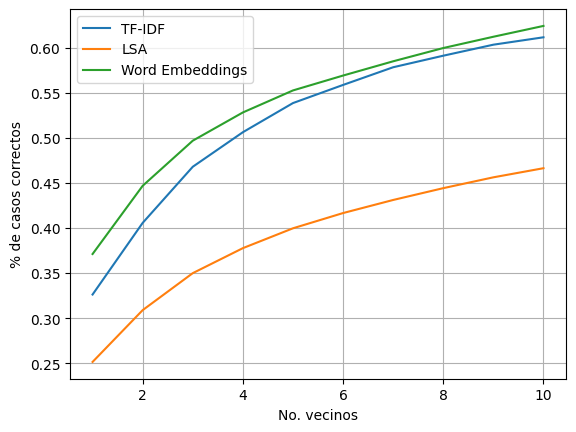


El tiempo de ejecución ha sido de 1.4187421480814615 minutos.


La accuracy promedio para cada método es:
[np.float64(0.5186518651865187), np.float64(0.39017901790179016), np.float64(0.5384238423842385)]

La accuracy de encontrar la frase más cercana (1 vecino), para cada método es:
0.3262326232623262 0.25152515251525154 0.37113711371137115

Y el mejor resultado promedio es:
0.5384238423842385


In [16]:
plt.plot(k_range, TFIDF_accuracies, label="TF-IDF")
plt.plot(k_range, LSA_accuracies, label="LSA")
plt.plot(k_range, Embedd_accuracies, label="Word Embeddings")
plt.xlabel("No. vecinos")
plt.ylabel("% de casos correctos")
plt.legend()
plt.grid()
plt.show()

print("\nEl tiempo de ejecución ha sido de {} minutos.\n".format((time.time() - t_ini)/60))

promedios = [np.mean(TFIDF_accuracies), np.mean(LSA_accuracies), np.mean(Embedd_accuracies)]

print("\nLa accuracy promedio para cada método es:")
print(promedios)

print("\nLa accuracy de encontrar la frase más cercana (1 vecino), para cada método es:")
print(TFIDF_accuracies[0], LSA_accuracies[0], Embedd_accuracies[0])

print("\nY el mejor resultado promedio es:")
print(np.max(promedios))